In [1]:
import os
import numpy as np
import pandas as pd
from pandas.plotting import table
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
from bellotti_r_master_thesis.isodar_scan_helper_functions import AdjustedRSquared
from bellotti_r_master_thesis.ml_helper_functions import AdjustedRSquaredSeparated

In [2]:
seed = 49857
tf.random.set_seed(seed)
np.random.seed(seed)

# Config

In [3]:
datafile = '/data/user/boiger_r/invertible_network_paper_data/data_sonali/samples_5000_short.hdf5'

In [4]:
model_name = 'isodar_forward_model'

In [5]:
model_dir = '/data/user/boiger_r/invertible_network_paper_results5000/models_30_11_2020/isodar/models'

In [14]:
#plot_dir = '/data/user/boiger_r/invertible_network_paper_results5000/models_30_11_2020/isodar/forward_model1/plots/model'
plot_dir ='/data/user/boiger_r/invertible_network_paper_results5000/models_30_11_2020/isodar/optimisation_paper_7/plots/plots_paper'


if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [7]:
dvars = ['pr0','r0','rfphi','sigmax','sigmay','sigmaz']
qois = ['Number of Macro Particles', 'Mean Bunch Energy', 'RMS Beamsize in x',
       'RMS Beamsize in y', 'RMS Beamsize in s', 'Halo in x', 'Halo in y',
       'Halo in z', 'Normalized Emittance x', 'Normalized Emittance y',
       'Normalized Emittance s', 'energy spread of the beam','particle_losses']
qoi_labels = {'Number of Macro Particles':r'$N_{MP}$', 'Mean Bunch Energy':r'$E$', 'RMS Beamsize in x':r'$\sigma_x$',
       'RMS Beamsize in y':r'$\sigma_y$', 'RMS Beamsize in s':r'$\sigma_z$', 'Halo in x':r'$h_x$', 'Halo in y':r'$h_y$',
       'Halo in z':r'$h_z$', 'Normalized Emittance x':r'$\epsilon_x$', 'Normalized Emittance y':r'$\epsilon_y$',
       'Normalized Emittance s':r'$\epsilon_z$', 'energy spread of the beam':r'$\Delta E$','particle_losses':r'$N_l$'}

# Load the model and the data

In [8]:
custom_objects = {'AdjustedRSquared': AdjustedRSquared}

kwargs = {'custom_objects': custom_objects,
          'compile': False}

surr = KerasSurrogate.load(model_dir, model_name, model_kwargs=kwargs)


In [9]:
dvar = pd.read_hdf(datafile, key='dvar')
qoi = pd.read_hdf(datafile, key='qoi')
qoi_columns = qoi.columns
n_in = dvar.shape[1]

dvar_trainval, dvar_test, qoi_trainval, qoi_test = train_test_split(dvar,
                                                                    qoi,
                                                                    test_size=0.2)
dvar_test.reset_index(drop=True, inplace=True)
qoi_test.reset_index(drop=True, inplace=True)

dvar_trainval.reset_index(drop=True, inplace=True)
qoi_trainval.reset_index(drop=True, inplace=True)

kf = KFold(n_splits=5, random_state=76, shuffle=True)

train_ind, val_ind = next(kf.split(dvar_trainval))

dvar_train = dvar_trainval.values[train_ind]
dvar_val = dvar_trainval.values[val_ind]
qoi_train = qoi_trainval.values[train_ind]
qoi_val = qoi_trainval.values[val_ind]

In [10]:
qoi['particle_losses']=2e4-qoi['Number of Macro Particles']
qoi_test['particle_losses']=2e4-qoi_test['Number of Macro Particles']

/data/user/boiger_r/invertible_neural_net/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
print(dvar_train.shape, dvar_test.shape, dvar_val.shape)

(3200, 6) (1000, 6) (800, 6)


In [16]:
print(qoi_train.shape, qoi_test.shape, qoi_val.shape)

(3200, 12) (1000, 13) (800, 12)


# Predict

In [17]:
qoi_pred = surr.predict(dvar_test)
qoi_pred = pd.DataFrame(data=qoi_pred, columns=qoi_columns)
qoi_pred['particle_losses']=2e4-qoi_pred['Number of Macro Particles']

# Calculate metrics

In [18]:
res = qoi_test - qoi_pred

q = np.arange(0.1, 1.0, 0.05)
q = np.append(q, [0.98, 0.99])
q = np.round(q, decimals=3)
quantiles = res.abs().quantile(q)
quantiles.to_csv(f'{plot_dir}/forward_prediction_residual_quantiles_by_longitudinal_pos.csv', sep='\t')

In [19]:
metric = AdjustedRSquaredSeparated(dvar_test.shape[0], dvar_test.shape[1])

r2_adj = metric.call(qoi_test.values, qoi_pred.values).numpy()
r2_adj = pd.Series(data=r2_adj, index=qoi.columns)
r2_adj = np.round(r2_adj, decimals=2)
r2_adj = pd.DataFrame(r2_adj).T

In [20]:
r2_adj = pd.DataFrame(r2_adj).rename(columns=qoi_labels)

In [21]:
r2_adj.values

array([[1.  , 1.  , 0.97, 0.96, 0.85, 0.9 , 0.95, 0.86, 0.99, 0.99, 0.82,
        0.98, 1.  ]])

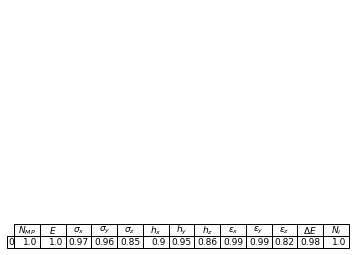

In [22]:
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, r2_adj)  # where df is your data frame

#plt.savefig(f'{plot_dir}/r2_adj.png')

In [23]:
rel_error = (qoi_pred - qoi_test) / qoi_test * 100.
rel_error = pd.DataFrame(rel_error, columns=qoi.columns).abs()

In [24]:
rel_error_table = np.round(rel_error.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}, columns=qoi_labels), decimals=2)

In [25]:
rel_error_table

$N_{MP}$   $E$  $\sigma_x$  $\sigma_y$  $\sigma_z$  $h_x$  $h_y$  $h_z$  \
50%      0.17  0.00        0.67        0.66        1.09   1.89   1.57   1.90   
75%      0.30  0.01        1.16        1.13        1.87   3.23   2.75   3.30   
90%      0.44  0.01        1.74        1.63        2.67   4.65   4.00   4.65   
95%      0.54  0.02        2.07        2.05        3.24   5.53   5.00   5.56   
99%      0.75  0.03        2.80        3.09        4.41   7.62   7.07   7.98   

     $\epsilon_x$  $\epsilon_y$  $\epsilon_z$  $\Delta E$  $N_l$  
50%          0.95          0.94          1.58        0.87   0.58  
75%          1.71          1.78          2.64        1.50   0.99  
90%          2.45          2.69          4.05        2.19   1.45  
95%          3.31          3.44          5.17        2.63   1.72  
99%          4.67          4.91          6.91        3.64   2.24

## Relative Errors

In [26]:
rel_error_table1 = rel_error_table.drop(columns = "$N_{MP}$")

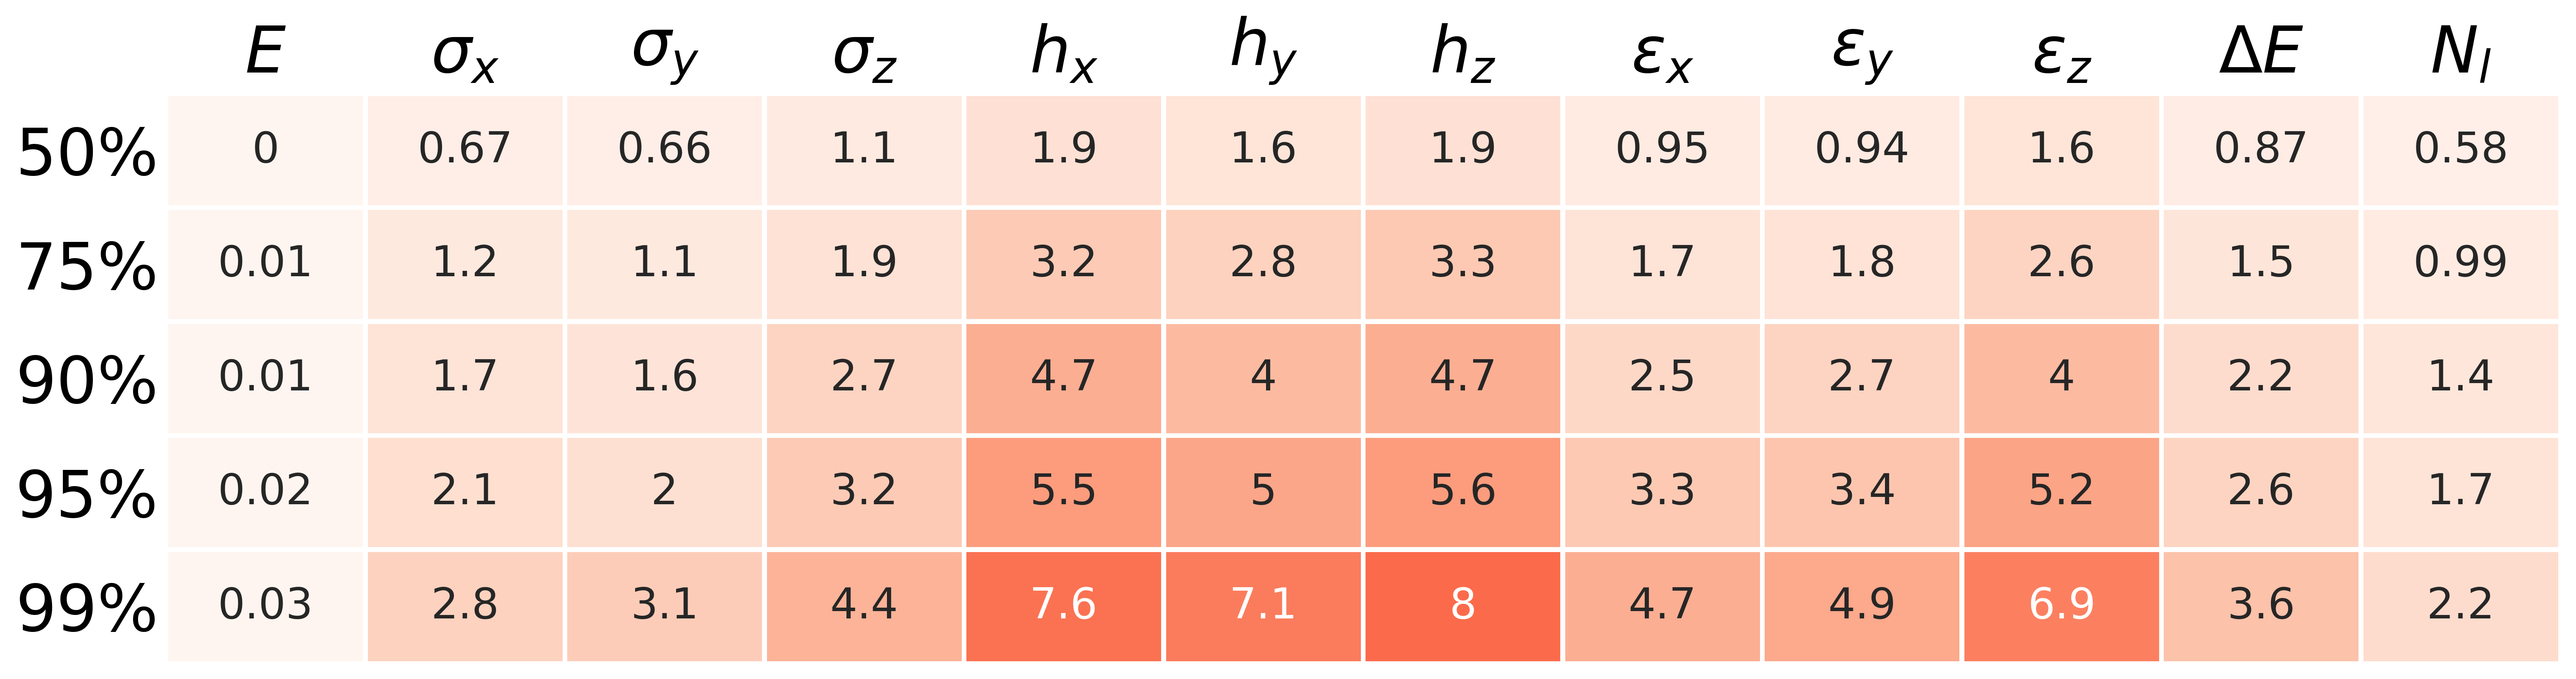

In [28]:
fig, ax = plt.subplots(figsize=(16, 4.5), dpi=400)

sns.heatmap(rel_error_table1,
            cmap='Reds',
            annot=True,
            linewidths=2.,
            vmin=0.,
            vmax=16.,
            annot_kws={'fontsize': 20},
#            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            cbar = False,
            ax=ax)
ax.tick_params(labelsize=30, length=0)
ax.tick_params(axis='y', rotation=0)
ax.xaxis.tick_top()

# adjust the size of the colorbar label
#fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=30);
#fig.axes[1].tick_params(labelsize=17)

fig.tight_layout(rect=(0, 0, 1.05, 1))
fig.savefig(f'{plot_dir}/isodar_forward_rel_error_percentiles.jpg', bbox_inches='tight')

## Residuals

In [26]:
surr.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 80)                560       
_________________________________________________________________
dense_1 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_2 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_4 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_5 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_6 (Dense)              (None, 12)                9

In [27]:
params = pd.DataFrame(data=[res.mean(), res.std()], index=['mean', 'std'])

In [28]:
params

Number of Macro Particles  Mean Bunch Energy  RMS Beamsize in x  \
mean                  -3.774197           0.002149           0.000003   
std                   41.939372           0.009222           0.000027   

      RMS Beamsize in y  RMS Beamsize in s  Halo in x  Halo in y  Halo in z  \
mean           0.000004           0.000002  -0.009746   0.000953  -0.006767   
std            0.000026           0.000025   0.119158   0.083976   0.098302   

      Normalized Emittance x  Normalized Emittance y  Normalized Emittance s  \
mean            8.260765e-10            1.658561e-09            1.512657e-10   
std             9.151497e-09            1.026792e-08            5.024568e-09   

      energy spread of the beam  particle_losses  
mean                   0.000420         3.774197  
std                    0.002281        41.939372

In [29]:
params.to_csv(f'{plot_dir}/residual_parameters.tsv', sep='\t')

# Calculate time needed for one forward prediction

In [30]:
test_data1 = dvar_test.copy()
test_data1 = pd.concat([test_data1]*1048, ignore_index=True)
test_data1 = pd.concat([test_data1,test_data1.iloc[0:576]],ignore_index=True)

In [31]:
print('2e20=1048576')
test_data1

2e20=1048576


pr0          r0       rfphi    sigmax    sigmay    sigmaz
0        0.002301  119.183506  283.690298  0.000984  0.003091  0.004939
1        0.002270  119.324810  283.725229  0.000954  0.003129  0.004968
2        0.002257  119.181506  283.800765  0.000958  0.002854  0.005145
3        0.002329  119.510230  283.872806  0.000973  0.003063  0.005034
4        0.002344  117.893895  283.104997  0.001009  0.002882  0.004819
...           ...         ...         ...       ...       ...       ...
1048571  0.002309  117.109347  283.647208  0.000953  0.002857  0.004993
1048572  0.002322  119.631804  283.751482  0.000952  0.003017  0.005001
1048573  0.002310  119.430772  283.008008  0.000977  0.002877  0.004979
1048574  0.002256  116.462808  283.875962  0.001032  0.002908  0.005085
1048575  0.002284  118.809063  283.484354  0.001020  0.002876  0.005231

[1048576 rows x 6 columns]

In [33]:
start = time.time()
qoi_pred_timing = surr.predict(test_data1)
end = time.time()
time2 = end-start
print(time2)  

KeyboardInterrupt: 

In [ ]:
time2_final = time2/1048576
print(time2_final)

In [34]:
test_data1.keys()

Index(['pr0', 'r0', 'rfphi', 'sigmax', 'sigmay', 'sigmaz'], dtype='object')

In [35]:
steps = 1048576
pr0_rand = np.random.uniform(0.002254,0.002346,steps)
r0_rand = np.random.uniform(115.9,119.9,steps)
rfphi_rand = np.random.uniform(283.0,287.0,steps)
sigmax_rand = np.random.uniform(0.00095,0.00105,steps)
sigmay_rand = np.random.uniform(0.00285,0.00315,steps)
sigmaz_rand = np.random.uniform(0.00475,0.00525,steps)

In [37]:
test_data2 = pd.DataFrame({'pr0': pr0_rand, 'r0': r0_rand,'rfphi':rfphi_rand,'sigmax':sigmax_rand,'sigmay':sigmay_rand,'sigmaz':sigmaz_rand}, 
                  columns=test_data1.keys())
test_data2

pr0          r0       rfphi    sigmax    sigmay    sigmaz
0        0.002346  118.395763  285.234246  0.000970  0.003071  0.004814
1        0.002311  117.352808  284.285406  0.001048  0.002858  0.004796
2        0.002264  117.925987  283.409443  0.001041  0.003104  0.005042
3        0.002280  116.558574  284.799846  0.000979  0.003039  0.004755
4        0.002321  119.051476  283.924079  0.000982  0.002966  0.004893
...           ...         ...         ...       ...       ...       ...
1048571  0.002265  116.272095  285.224356  0.001018  0.003089  0.004787
1048572  0.002311  117.988365  283.401988  0.001006  0.002919  0.004910
1048573  0.002271  118.741061  283.565648  0.001016  0.003100  0.005151
1048574  0.002341  116.643724  283.278326  0.000959  0.002875  0.005022
1048575  0.002269  118.394388  286.720134  0.000966  0.003140  0.005182

[1048576 rows x 6 columns]

In [38]:
start = time.time()
qoi_pred_timing = surr.predict(test_data2)
end = time.time()
time3 = end-start
print(time3)  

KeyboardInterrupt: 

In [ ]:
time3_final = time3/steps
print(time3_final)